In [1]:
from __init__ import * 
import __template__new as mcj
import numpy as np
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (16, 9),
          'axes.grid': False,
          'grid.linestyle': '-',
          'grid.alpha': 0.2,
          'lines.markersize': 5.0,
          'xtick.minor.visible': True,
          'xtick.direction': 'in',
          'xtick.major.size': 10.0,
          'xtick.minor.size': 5.0,
          'xtick.top': True,
          'ytick.minor.visible': True,
          'ytick.direction': 'in',
          'ytick.major.size': 10.0,
          'ytick.minor.size': 5.0,
          'ytick.right': True,
          'errorbar.capsize': 0.0,
          'figure.max_open_warning': 50,
})
from scipy.optimize import curve_fit
import yaml
from iminuit import Minuit
from iminuit.cost import LeastSquares
import importlib



with open('yaml/data.yaml', 'r') as file:
    runs_info = yaml.safe_load(file)
    
make_dir('Hardware_Fit')
make_dir('Hardware_Fit/parqs')
make_dir('Hardware_Fit/figures')
make_dir('npys')
make_dir('parqs')
make_dir('generic_figures')


"La cartella 'generic_figures' esiste già."

In [2]:
import random

In [3]:
crystal = 'BGO'
beam = 'e'
angle = 0
ch = 2
laser = True

In [4]:
beam_text = r'$e^+$' if beam == 'e' else r'$\mu^+$'

In [5]:
print(f'Running script for {crystal} with {beam} at {angle} degrees')
if not laser:
    print('Template from analytic function')
else:
    print('Template from Laser Calibration Waveform')

Running script for BGO with e at 0 degrees
Template from Laser Calibration Waveform


In [6]:
mean =  {}
df = {}

In [7]:
print(f'Reading Files')
wf, df = mixing_run(runs_info[crystal][beam][angle])
times = wf[0]['times']

Reading Files
0


100%|██████████| 40039/40039 [00:26<00:00, 1532.00it/s]


40039


In [8]:
df[f'amplitude_media_channel{ch}'] = df[f'amplitude_media_channel{ch}'].fillna(0)

In [9]:
with open('yaml/laser_calib.yaml', 'r') as file:
    log_laser = yaml.safe_load(file)

In [10]:
if ch == 2:
    sipm = '6x6' 
    ampl = 18

In [11]:
if laser:
    path_data = '/eos/user/m/mcampajo/MAXICC_TB_analysis/data_calibrazioni/laser/'
    create_mean_wf(log_laser[sipm][ampl], path_data)

I file npys/Times_478.npy e npys/Mean_Waveform_478.npy esistono già


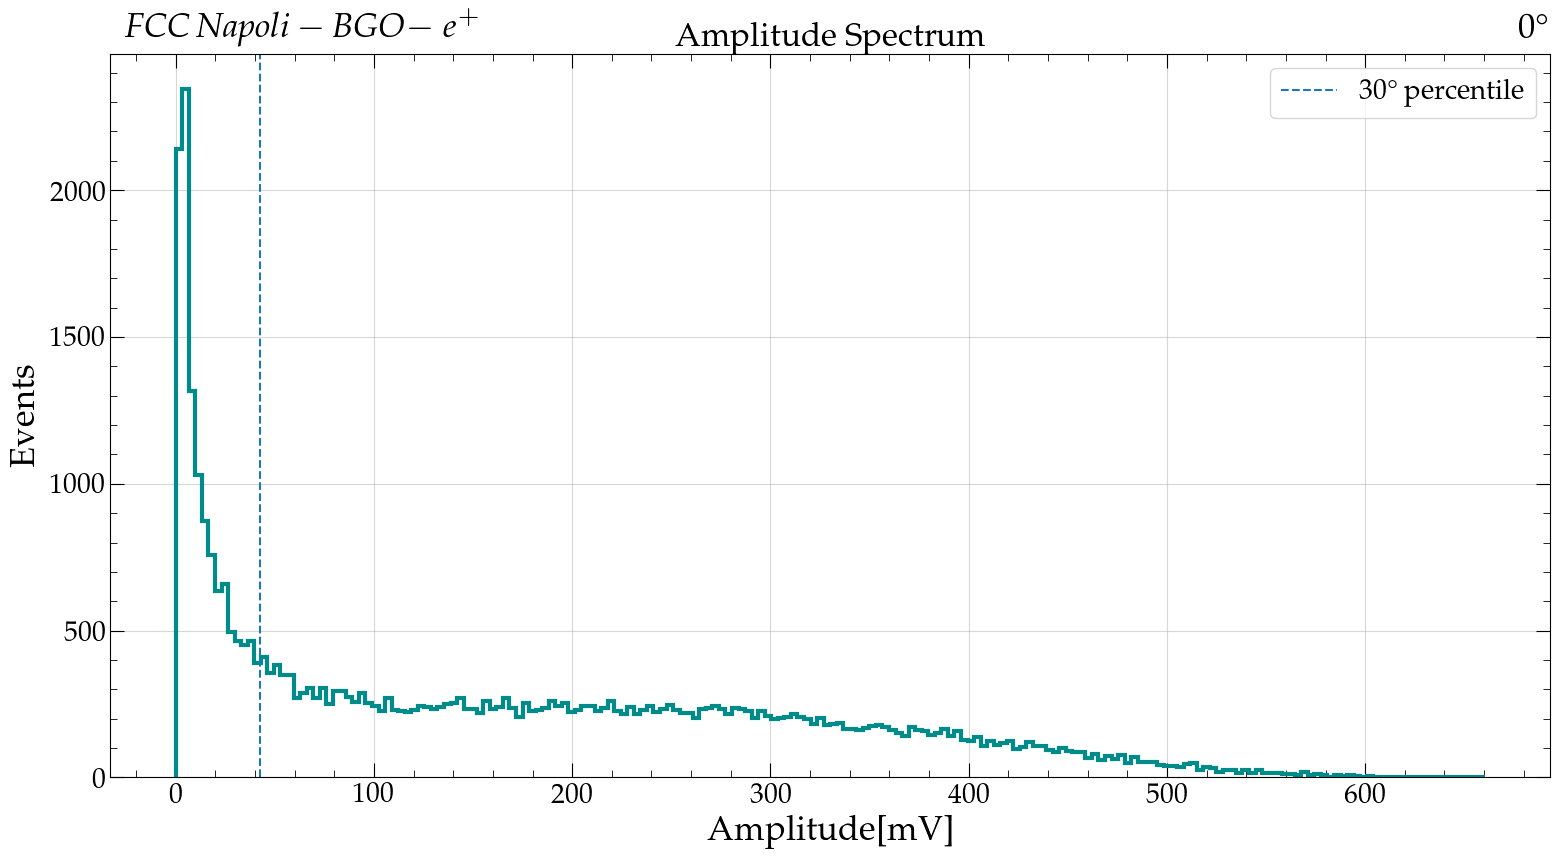

In [14]:
perc = 30
m = np.percentile(df[f'amplitude_media_channel{ch}'], perc)
custom_plot_layout(title=f'Amplitude Spectrum', xlabel="Amplitude[mV]", ylabel="Events",  figsize=(16, 9), angle = angle, crystal = crystal, beam = beam_text)
hist_, bins, l = plt.hist(df[f'amplitude_media_channel{ch}'], bins = 200, histtype = 'step', linewidth = 3, color = 'darkcyan')
plt.axvline(m, linestyle='--', label=f'{perc}° percentile')
plt.grid(alpha = 0.5)
plt.yscale('linear')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig(f'generic_figures/amplitude_spectrum_{crystal}_{beam}_{angle}.png', dpi = 300)

In [15]:
ev_ids = df.query(f'amplitude_media_channel{ch} > {m}')['__event__']
ev_ids = ev_ids.to_list()

sampled_numbers = random.sample(ev_ids, 10)

print(sampled_numbers)



[39173, 24406, 20202, 20097, 37987, 31744, 3108, 25199, 25804, 37746]


In [16]:
if ch == 2:
    SPR = mcj.ampl6x6_18

In [17]:
dt = times[1]-times[0]
dt = dt.round(3)
ranger = [int(times.min()), int(times.max())]
npoints = len(times)
interS_template, interC_template, bins = mcj.get_templates(crystal,
                                                           sipm,
                                                           SPR,
                                                           ranger,
                                                           dt,
                                                           nsimS=1E7,
                                                           nsimC=1E7,
                                                           normalize=True,
                                                           graphics=False,
                                                           Laser_Calib = laser, 
                                                           run = log_laser[sipm][ampl])

In [18]:

def myfunc(x, c, s, t0, of):
    return mcj.wf_function(x, interS_template, interC_template, c, s, t0, of)

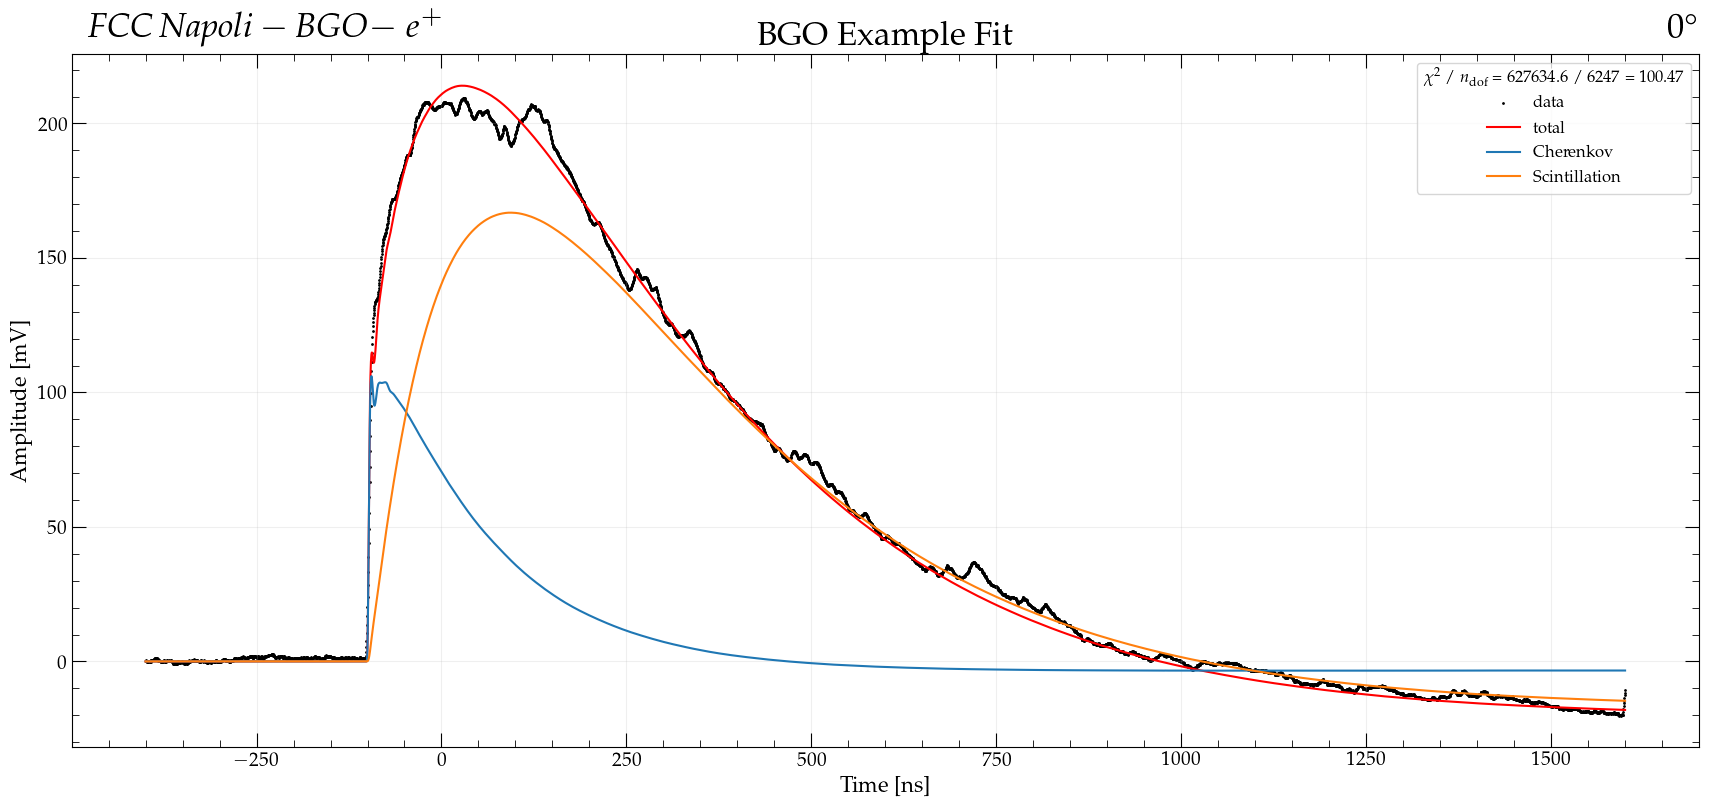

In [21]:

for ev_id in [sampled_numbers[0]]:
    WFT = wf[ev_id]['2media']
    sigmas = np.std(WFT[:100])

    least_squares = LeastSquares(times, WFT, sigmas, myfunc)
    m = Minuit(least_squares, 100, 100, 0, 0)
    m.fixed['of'] = True
    m.migrad() 

    fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fval/m.ndof:.2f}" ]
    custom_plot_layout(title = f'{crystal} Example Fit', xlabel=r"Time [ns]", figsize = (21,9), angle = angle, crystal = crystal, beam = beam_text)
    plt.scatter(times, WFT, s=1, color='black', label="data")
    plt.plot(times, myfunc(times, *m.values), label="total", color='red')
    plt.plot(times, myfunc(times, m.values['c'], 0, m.values['t0'], m.values['of']), label="Cherenkov", color='C0')
    plt.plot(times, myfunc(times, 0, m.values['s'], m.values['t0'], m.values['of']), label="Scintillation", color='C1')

    plt.legend(title="\n".join(fit_info), fontsize=12, title_fontsize=12)
    plt.xlabel('Time [ns]', fontsize=16)
    plt.ylabel('Amplitude [mV]', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(f'BGO - 10GeV e+ - theta={theta}, run {run_index}, event {event} ', size=16)
    #plt.axvline(x=m.values['x0'])
    plt.grid()
    #plt.xlim(-150, 50)
    plt.savefig(f'generic_figures/Example_Fit{crystal}_{beam}_{angle}.png', dpi = 300)
    plt.show()
